In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# taken from end makemore2. most values updated to match K's

# no. of chars used in context
block_size = 3

# dimensionality of embedding table
emb_dims = 10
n_weights = block_size * emb_dims

# no. of neurons
n_hidden = 200

# size of batches
batch_size = 32

# number of training runs
train_runs = 20001

# learning rate
l_rate_init = 0.1

#     learning rate decay
decay_factor = 0.99999

# others
# ???

In [4]:
# get all words
words = open('names.txt', 'r').read().splitlines()


# get indexes between chars and ints
chars = sorted(list(set(''.join(words))))
s_to_i = {s:i+1 for i, s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i:s for s, i in s_to_i.items()}
vocab_size = len(s_to_i)
print(f'First 15 words: {words[:15]}\n\ns to i: {s_to_i}\n\ni to s: {i_to_s}\n\nVocab size: {vocab_size}')

First 15 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella']

s to i: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

i to s: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

Vocab size: 27


In [5]:
# define func for building dataset

def build_dataset(words, block_size):
    block_size = block_size
    X, Y = [], []
    for word in words:
        # print(word)
        context = [0] * block_size
    
        for char in word + '.':
            ix = s_to_i[char]
            X.append(context)
            Y.append(ix)
            # print(''.join(i_to_s[i] for i in context), '->', i_to_s[ix])
            context = context[1:] + [ix] # crop first character and append next
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    print(f'X shape: {X.shape} \tX dtype: {X.dtype} \tY shape: {Y.shape} \tY dtype: {Y.dtype}')
    return X, Y

In [8]:
# set train, dev, test sets

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_trn, Y_trn = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_tst, Y_tst = build_dataset(words[n2:], block_size)

X shape: torch.Size([182606, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([182606]) 	Y dtype: torch.int64
X shape: torch.Size([22697, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22697]) 	Y dtype: torch.int64
X shape: torch.Size([22844, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22844]) 	Y dtype: torch.int64


In [155]:
g = torch.Generator().manual_seed(2147483647)
# updated 1st arg to vocab_size. had already done most of what K does here at the end of makemore2
C = torch.randn((vocab_size, emb_dims), generator = g) 
# updated var name n_neurons to n_hidden as per K. more accurate
W1 = torch.randn((n_weights, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g) 
W2 = torch.randn((n_hidden, vocab_size), generator = g) 
b2 = torch.randn(vocab_size, generator = g) 

# get param count
parameters = [C, W1, b1, W2, b2]
print(f'No. parameters: {sum(p.nelement() for p in parameters)}')

No. parameters: 11897


In [156]:
for p in parameters:
    p.requires_grad = True 

In [157]:
step_i = []
loss_i = []
log_loss_i = []

In [172]:
# train
def train(train_runs, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i):
    for _ in range (train_runs):
        ix = torch.randint(0, X_trn.shape[0], (batch_size,), generator = g)
        Xb, Yb = X_trn[ix], Y_trn[ix]
        # forward pass

        # NB small formatting updates after Karpathy

        emb = C[Xb] # embed chars into vecs of size N x block_size x emb_dims (can't work out exactly what N is for the moment)
        emb_concat = emb.view(emb.shape[0], -1) # concat vectors to N x (block_size x emb_dims)
        h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation, N x n_hidden
        h = torch.tanh(h_preact) # hidden layer, N x vocab_size
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None 
        loss.backward() 

        # update
        # l_rate = l_rate_init * (decay_factor ** _) # different from Karpathy's, below
        l_rate = 0.1 if _ < 100000 else 0.01 # K's

        for p in parameters:
            p.data += -l_rate * p.grad

        step_i.append(_)
        loss_i.append(loss) 
        log_loss_i.append(loss.log10().item()) 

        if _ % 2500 == 0:
            print(f'Iter: {_}\t'
                  f'L_rate: {round(l_rate, 5)}\t'
                  f'Loss: {round(loss.item(), 5)}\t'
                  f'Loss MA10: {round(np.mean([l.detach().numpy() for l in loss_i[-10:]]), 5)}')
        
    return h_preact, h, logits, loss

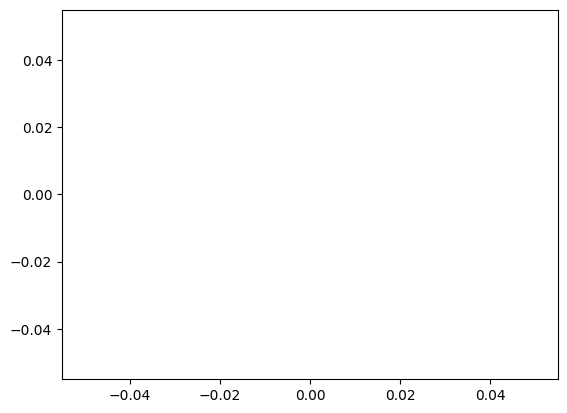

In [158]:
plt.plot(log_loss_i)

In [159]:
# new code from Karpathy to track performance of dataset splits

@torch.no_grad() # decorator to disable gradient tracking (and thereby increase efficiency)
def split_loss(split):
    X, Y = {
        'train': (X_trn, Y_trn),
        'dev': (X_dev, Y_dev),
        'test': (X_tst, Y_tst)
           }[split]
    emb = C[X] # embed chars into vecs of size N x block_size x emb_dims
    emb_concat = emb.view(emb.shape[0], -1) # concat vectors to N x (block_size x emb_dims)
    h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation, N x n_hidden
    h = torch.tanh(h_preact) # hidden layer, N x vocab_size
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y) # loss function
    print(f'{split}: {loss.item()}')
    
split_loss('train')
split_loss('dev')
split_loss('test')

train: 25.998157501220703
dev: 26.06113624572754
test: 26.01677894592285


In [192]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 2304)

def name_generator(g, block_size, C, W1, b1, W2, b2, names):
    for _ in range(names):
        out = []
        context = [0] * block_size
        while True:
            emb = C[torch.tensor([context])]  
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim = 1)
            ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:
                break

        print(''.join(i_to_s[i] for i in out))
    
name_generator(g, block_size, C, W1, b1, W2, b2, 20)

aryanslee.
jose.
khirasha.
bryn.
atrevakiyah.
haraide.
tyrdang.
dalle.
damaryan.
demaire.
madylena.
den.
sus.
bara.
fine.
affilalisy.
livagda.
addy.
carden.
wicarmargy.


In [161]:
# initial loss is way out (around 27)
# neg log prob for 27 chars should be around 3.3
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [162]:
# 4D example of issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log() # just indexing in to probs (uniform dist) at random 
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [163]:
# BUT, if other values are extreme, we get high loss
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim = 0)
loss = -probs[2].log() # just indexing in to probs (uniform dist) at random 
logits, probs, loss

(tensor([-16.9188,  -2.5004,   8.2928,   0.8533]),
 tensor([1.1232e-11, 2.0526e-05, 9.9939e-01, 5.8717e-04]),
 tensor(0.0006))

In [106]:
# re-initialise and train, outputting loss from just first iteration
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_trn, Y_trn = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_tst, Y_tst = build_dataset(words[n2:], block_size)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dims), generator = g) 
W1 = torch.randn((n_weights, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g) 
W2 = torch.randn((n_hidden, vocab_size), generator = g) 
b2 = torch.randn(vocab_size, generator = g) 

# get param count
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True 
    
step_i = []
loss_i = []
log_loss_i = []

train(1, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i)

X shape: torch.Size([182443, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([182443]) 	Y dtype: torch.int64
X shape: torch.Size([22930, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22930]) 	Y dtype: torch.int64
X shape: torch.Size([22774, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22774]) 	Y dtype: torch.int64
Iter: 0	L_rate: 0.1	Loss: 25.45935	Loss MA10: 25.4593505859375


(tensor([[  3.9990,   1.6832,  -2.6482,  ...,  -3.6486,   7.9388,   4.2100],
         [  0.2366,  -1.0298,   1.3311,  ...,  -2.6519,  -4.0272,   0.3195],
         [ -4.9033,  -0.6593,  -3.0338,  ...,  -5.8473,  -3.6177,   4.9607],
         ...,
         [ -2.9766,  -0.2452,   1.7540,  ...,  -5.1640,   3.9082,  15.4719],
         [  9.0678, -10.7850,  -5.1990,  ...,  -4.5949,  -6.5185,  -0.1172],
         [ -1.4246,   0.8337, -13.5671,  ...,   5.9078,  -9.9604, -13.0128]],
        grad_fn=<AddBackward0>),
 tensor([[ 0.9993,  0.9333, -0.9900,  ..., -0.9986,  1.0000,  0.9996],
         [ 0.2323, -0.7738,  0.8695,  ..., -0.9901, -0.9994,  0.3091],
         [-0.9999, -0.5779, -0.9954,  ..., -1.0000, -0.9986,  0.9999],
         ...,
         [-0.9948, -0.2404,  0.9418,  ..., -0.9999,  0.9992,  1.0000],
         [ 1.0000, -1.0000, -0.9999,  ..., -0.9998, -1.0000, -0.1167],
         [-0.8905,  0.6825, -1.0000,  ...,  1.0000, -1.0000, -1.0000]],
        grad_fn=<TanhBackward0>),
 tensor([[-8.19

In [110]:
# re-initialise and do full training run with adjusted W2 and B2
# NB - this time we set the HPs so that the logits are more uniform at first run and loss is less extreme

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_trn, Y_trn = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_tst, Y_tst = build_dataset(words[n2:], block_size)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dims), 	generator = g) 
W1 = torch.randn((n_weights, n_hidden), 	generator = g)
b1 = torch.randn(n_hidden, 					generator = g) 
# NB - DO NOT set W2 to zeroes (K asserts at this point in vid, does not yet explain)
W2 = torch.randn((n_hidden, vocab_size), 	generator = g) * 0.1 # scalar applied to logits to reduce values on initial run
b2 = torch.randn(vocab_size, 				generator = g) * 0 # set bias on logits to zero for initial run

# get param count
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True 
    
step_i = []
loss_i = []
log_loss_i = []

h_preact, h, logits, loss = train(10001, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i)

X shape: torch.Size([182548, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([182548]) 	Y dtype: torch.int64
X shape: torch.Size([22751, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22751]) 	Y dtype: torch.int64
X shape: torch.Size([22848, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22848]) 	Y dtype: torch.int64
Iter: 0	L_rate: 0.1	Loss: 4.22263	Loss MA10: 4.222630023956299
Iter: 2500	L_rate: 0.09753	Loss: 2.65605	Loss MA10: 2.455080032348633
Iter: 5000	L_rate: 0.09512	Loss: 2.20936	Loss MA10: 2.3960399627685547
Iter: 7500	L_rate: 0.09277	Loss: 2.33444	Loss MA10: 2.2918701171875
Iter: 10000	L_rate: 0.09048	Loss: 2.48675	Loss MA10: 2.3535499572753906


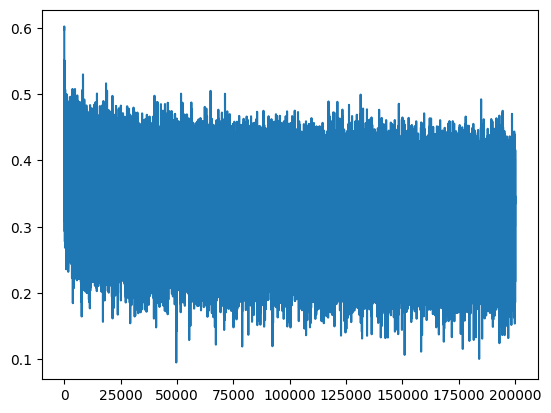

In [86]:
# NB no hockey stick shape on plot as initial loss was adjusted
plt.plot(log_loss_i)

In [164]:
# losses actually similar to earlier, no noticeable improvement (K gets a modest improvement)
split_loss('train')
split_loss('dev')
split_loss('test')

train: 25.998157501220703
dev: 26.06113624572754
test: 26.01677894592285


In [165]:
# next problem! 
# quick visualisation of h, lots of 1.0 and -1.0
h

tensor([[-0.9975,  1.0000, -1.0000,  0.9378,  0.9993,  0.9998, -0.9891, -0.6072,
          1.0000,  1.0000,  0.0251, -1.0000,  1.0000,  1.0000, -1.0000,  0.8585,
          1.0000, -0.9967,  0.9999, -0.9891, -0.5467, -0.9991, -1.0000, -0.9995,
         -1.0000, -0.4058,  1.0000, -0.9998,  1.0000,  0.9999,  0.9971,  0.9936,
         -1.0000, -1.0000,  1.0000,  1.0000, -0.6321,  0.9765,  0.9968,  0.9985,
         -1.0000,  1.0000,  1.0000,  1.0000, -1.0000,  0.8615, -1.0000,  1.0000,
          0.9990, -0.9546, -0.9869,  0.9675, -0.9944,  0.9962,  0.8092,  0.7738,
          1.0000,  0.9987,  1.0000,  0.9999,  0.9990,  1.0000, -0.9975,  0.9990,
         -0.1540,  1.0000,  1.0000,  1.0000,  0.9990,  1.0000,  1.0000, -0.9511,
         -0.9429, -0.9225,  1.0000, -0.9996,  1.0000, -0.0188,  0.9993,  0.9999,
          1.0000,  0.9995, -0.9876, -1.0000, -0.9825, -0.2593,  0.9019, -0.9992,
          0.9972,  1.0000,  0.5762, -0.6866,  0.9809, -1.0000,  0.0606,  1.0000,
         -0.7844, -1.0000, -

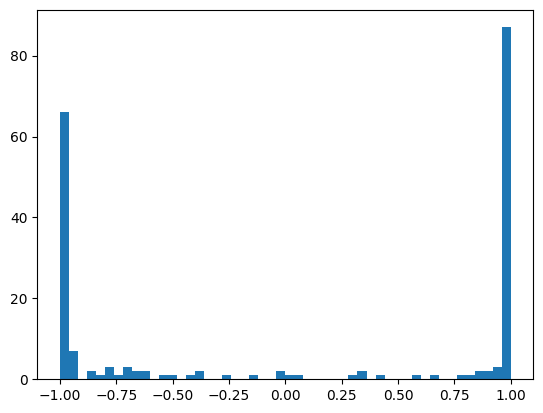

In [166]:
plt.hist(h.view(-1).tolist(), 50); # -1 puts this into one long 1D vector, tolist just converts to a py list of floats

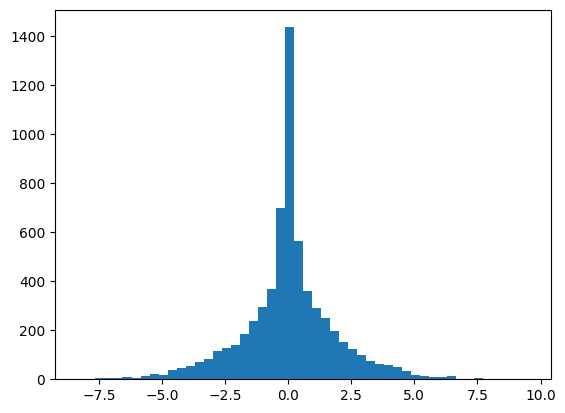

In [167]:
# why so many at the extremes? why tanh so active???
# range of h_preact is broad, and compressing all of these into a range of -1, 1 is capping and resulting in those extremes
plt.hist(h_preact.view(-1).tolist(), 50);

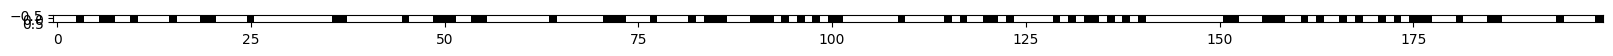

In [168]:
# what's happening if we have loads of 1s?
# how is back-propagation through tanh defined in micrograd (and presumably pytorch)?
# it gets the tanh t of x
# then during backward pass, takes out.grad and multiplies it with the local gradient, 1-t**2
# if tanh is very close to 1 or -1, then 1-t**2 = 0, and the gradient is, therefore, killed

# how do we start to visualise a solution
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest') # how often is (abs of h) above 0.99?

# every white cell is preventing the gradient from flowing backward
# a white column would represent a completely inert, or 'dead', neuron, which always fires 0 or 1 and can not learn

In [169]:
# sigmoid
# tanh
# ReLU
# maxout
# ELU
# all have this issue, as they all have flat parts

# leaky ReLU
# PreLU (?)
# is an example of an activation function which avoids this issue
# by applying a small linear function to <0 values

In [174]:
# re-initialise and do full training run with adjusted W1 and b1
# NB - this time we set the HPs so that the logits are more uniform at first run and loss is less extreme

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_trn, Y_trn = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_tst, Y_tst = build_dataset(words[n2:], block_size)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dims), 	generator = g) 
W1 = torch.randn((n_weights, n_hidden), 	generator = g) * 0.1
b1 = torch.randn(n_hidden, 					generator = g) * 0.01
# NB - DO NOT set W2 to zeroes (K asserts at this point in vid, does not yet explain)
W2 = torch.randn((n_hidden, vocab_size), 	generator = g) * 0.01 # scalar applied to logits to reduce values on initial run
b2 = torch.randn(vocab_size, 				generator = g) * 0 # set bias on logits to zero for initial run

# get param count
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True 
    
step_i = []
loss_i = []
log_loss_i = []

print(sum(p.nelement() for p in parameters))

X shape: torch.Size([182638, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([182638]) 	Y dtype: torch.int64
X shape: torch.Size([22723, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22723]) 	Y dtype: torch.int64
X shape: torch.Size([22786, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22786]) 	Y dtype: torch.int64
11897


In [175]:
train_runs = 100001
h_preact, h, logits, loss = train(train_runs, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i)

Iter: 0	L_rate: 0.1	Loss: 3.29652	Loss MA10: 3.2965199947357178
Iter: 2500	L_rate: 0.1	Loss: 2.1778	Loss MA10: 2.366489887237549
Iter: 5000	L_rate: 0.1	Loss: 2.03874	Loss MA10: 2.3362998962402344
Iter: 7500	L_rate: 0.1	Loss: 2.4197	Loss MA10: 2.3517301082611084
Iter: 10000	L_rate: 0.1	Loss: 2.40619	Loss MA10: 2.2939701080322266
Iter: 12500	L_rate: 0.1	Loss: 2.08721	Loss MA10: 2.1269400119781494
Iter: 15000	L_rate: 0.1	Loss: 2.03273	Loss MA10: 2.2816500663757324
Iter: 17500	L_rate: 0.1	Loss: 2.10439	Loss MA10: 2.14057993888855
Iter: 20000	L_rate: 0.1	Loss: 2.03538	Loss MA10: 2.2383298873901367
Iter: 22500	L_rate: 0.1	Loss: 2.37764	Loss MA10: 2.107609987258911
Iter: 25000	L_rate: 0.1	Loss: 2.03751	Loss MA10: 2.184890031814575
Iter: 27500	L_rate: 0.1	Loss: 2.75283	Loss MA10: 2.298190116882324
Iter: 30000	L_rate: 0.1	Loss: 1.78846	Loss MA10: 2.075850009918213
Iter: 32500	L_rate: 0.1	Loss: 2.39122	Loss MA10: 2.1601500511169434
Iter: 35000	L_rate: 0.1	Loss: 2.02089	Loss MA10: 2.0867500305175

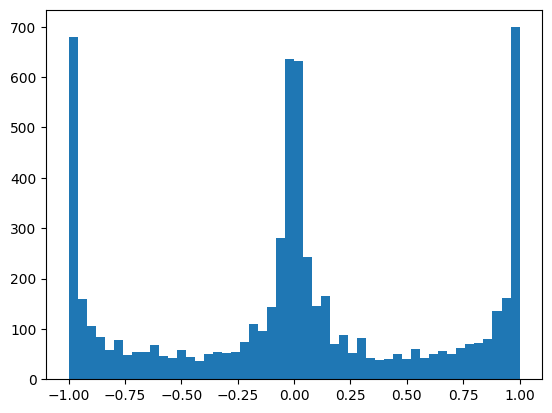

In [178]:
# run visualisations again
# bit puzzled that I'm still getting very visible capping. may have missed something in Karpathy's code
plt.hist(h.view(-1).tolist(), 50); # -1 puts this into one long 1D vector, tolist just converts to a py list of floats

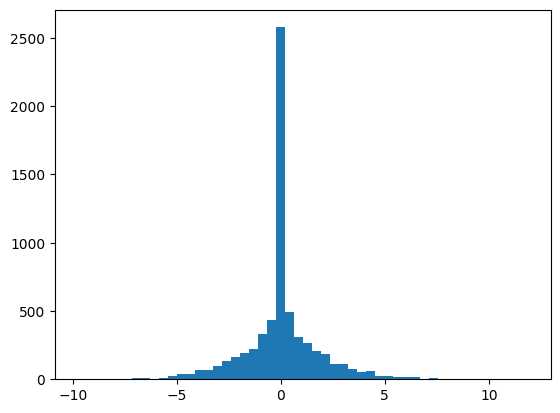

In [179]:
plt.hist(h_preact.view(-1).tolist(), 50);

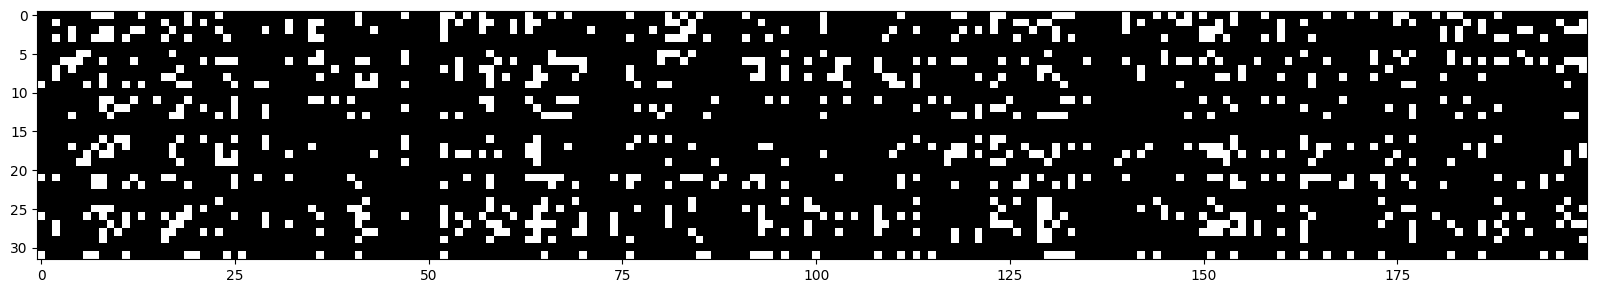

In [180]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest') # how often is (abs of h) above 0.99?

In [194]:
# actually worse than earlier. something must have gone wrong

split_loss('train')
split_loss('dev')
split_loss('test')

train: 2.1401333808898926
dev: 2.188962936401367
test: 2.1953110694885254


In [199]:
g = torch.Generator().manual_seed(2147483647 + 2304)

name_generator(g, block_size, C, W1, b1, W2, b2, 15)

aryanslee.
jose.
khirasha.
bryn.
atrevakiyah.
haraide.
tyrdang.
dalle.
damaryan.
demaire.
madylena.
den.
sus.
bara.
fine.


tensor(0.0082) tensor(0.9968)
tensor(-0.0017) tensor(3.0863)


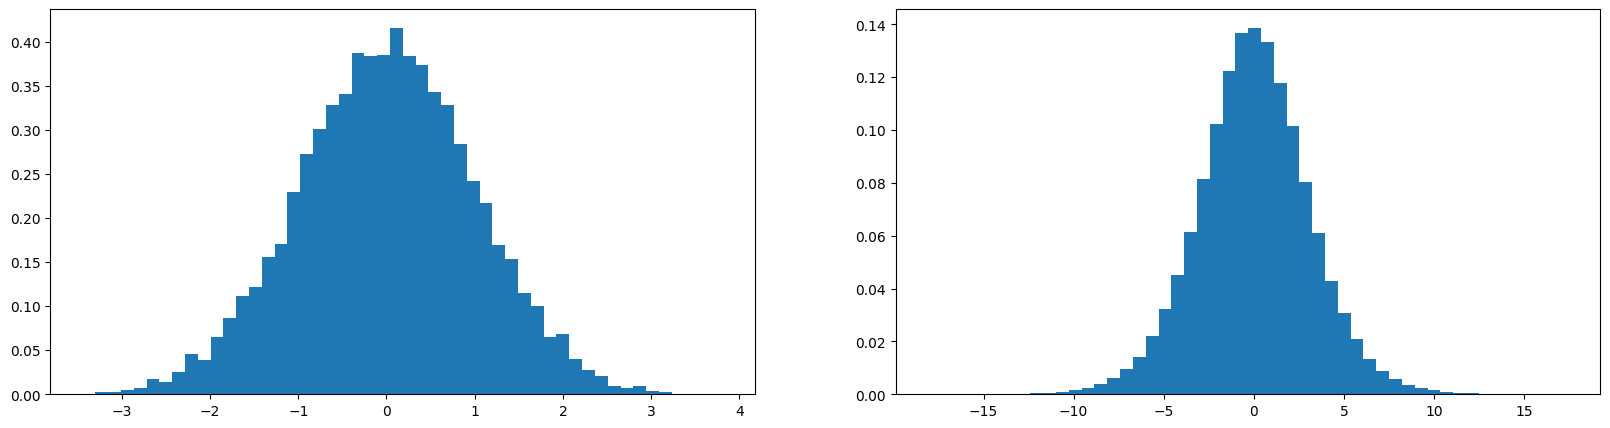

In [203]:
# discussion regarding intialisation/HPs etc

# an example:
x = torch.randn(1000, 10) # random inputs from gaussian with 1000 10D examples
w = torch.randn(10, 200) # weights also drawn from gaussian, hidden layer with 200 neurons
y = x @ w # neuron pre-activations
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(list(x.view(-1)), 50, density = True);
plt.subplot(122)
plt.hist(list(y.view(-1)), 50, density = True);

# NB mean remains around 0, s.d. has grown from 1 to around 3

tensor(-0.0071) tensor(0.9843)
tensor(0.0009) tensor(1.0013)


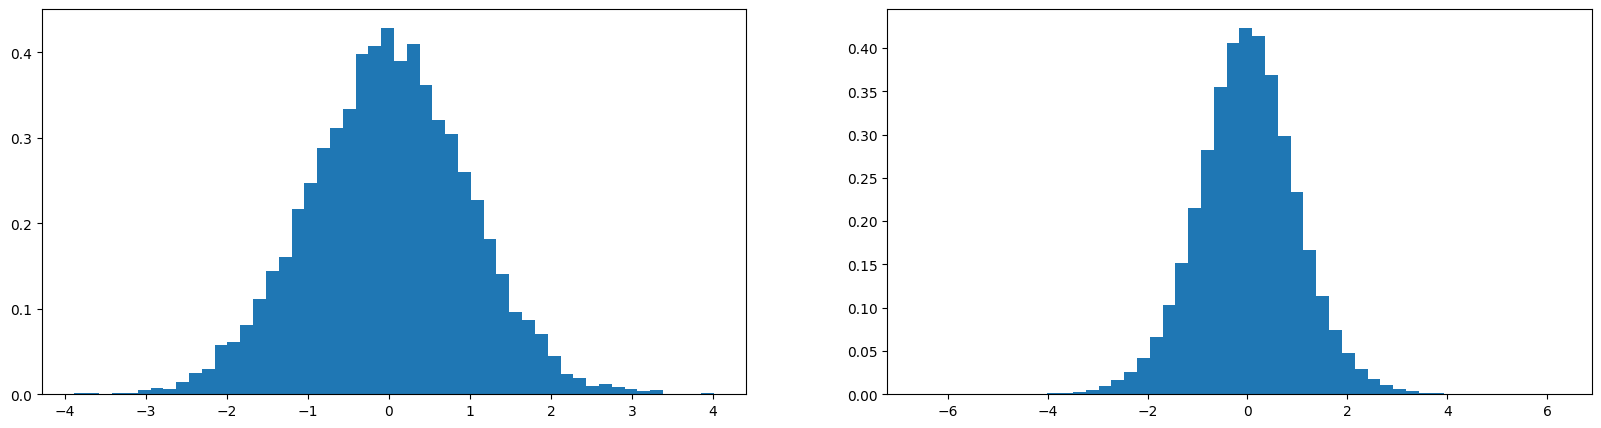

In [205]:
# question is: how do we scale weights to preserve normality in gaussian?

# an example:
x = torch.randn(1000, 10) # 
w = torch.randn(10, 200) / 10**0.5 # A: divide W by sqrt of "fan in" (if I heard Karpathy correctly) - it's the first argument
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.hist(list(x.view(-1)), 50, density = True);
plt.subplot(122)
plt.hist(list(y.view(-1)), 50, density = True);

# NB mean remains around 0, s.d. has grown from 1 to around 3

In [206]:
# further discussion about normalisation from paper by kaiming he
# includes necessity of applying gain (5/3 for tanh) etc
# modern innovations touched on which make this setup less finicky
# - residual connections
# - normalisation layers: batch normalisation, layer normalisation etc
# - better optimisation: RMS prop, Adam
# in practice sqrt of fan in works well 

In [208]:
# in our case, we want the s.d. of our W1 weights to be (5/3) / sqrt(n_weights)
kaiming_init = (5/3) / (n_weights**0.5)
kaiming_init

0.3042903097250923

In [211]:
# re-initialise with kaiming init

kaiming_init = (5/3) / (n_weights**0.5)
kaiming_init

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_trn, Y_trn = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_tst, Y_tst = build_dataset(words[n2:], block_size)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dims), 	generator = g) 
W1 = torch.randn((n_weights, n_hidden), 	generator = g) * kaiming_init
b1 = torch.randn(n_hidden, 					generator = g) * 0.01
# NB - DO NOT set W2 to zeroes (K asserts at this point in vid, does not yet explain)
W2 = torch.randn((n_hidden, vocab_size), 	generator = g) * 0.01 # scalar applied to logits to reduce values on initial run
b2 = torch.randn(vocab_size, 				generator = g) * 0 # set bias on logits to zero for initial run

# get param count
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True 
    
step_i = []
loss_i = []
log_loss_i = []

print(sum(p.nelement() for p in parameters))

X shape: torch.Size([182590, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([182590]) 	Y dtype: torch.int64
X shape: torch.Size([22806, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22806]) 	Y dtype: torch.int64
X shape: torch.Size([22751, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22751]) 	Y dtype: torch.int64
11897


In [216]:
train_runs = 200001
h_preact, h, logits, loss = train(train_runs, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i)

Iter: 0	L_rate: 0.1	Loss: 1.8467	Loss MA10: 2.0376999378204346
Iter: 2500	L_rate: 0.1	Loss: 2.00002	Loss MA10: 2.0969998836517334
Iter: 5000	L_rate: 0.1	Loss: 2.22787	Loss MA10: 2.1818900108337402
Iter: 7500	L_rate: 0.1	Loss: 2.05433	Loss MA10: 2.117039918899536
Iter: 10000	L_rate: 0.1	Loss: 2.08405	Loss MA10: 2.240999937057495
Iter: 12500	L_rate: 0.1	Loss: 2.10752	Loss MA10: 2.1807799339294434
Iter: 15000	L_rate: 0.1	Loss: 1.91214	Loss MA10: 2.293639898300171
Iter: 17500	L_rate: 0.1	Loss: 2.43829	Loss MA10: 2.139080047607422
Iter: 20000	L_rate: 0.1	Loss: 1.91089	Loss MA10: 2.2081799507141113
Iter: 22500	L_rate: 0.1	Loss: 2.10804	Loss MA10: 2.172729969024658
Iter: 25000	L_rate: 0.1	Loss: 2.16429	Loss MA10: 2.047149896621704
Iter: 27500	L_rate: 0.1	Loss: 2.16846	Loss MA10: 2.094909906387329
Iter: 30000	L_rate: 0.1	Loss: 1.89971	Loss MA10: 2.0974600315093994
Iter: 32500	L_rate: 0.1	Loss: 2.14383	Loss MA10: 2.162130117416382
Iter: 35000	L_rate: 0.1	Loss: 2.47916	Loss MA10: 2.1370000839233

In [213]:
# finally, much better
split_loss('train')
split_loss('dev')
split_loss('test')

train: 2.0368690490722656
dev: 2.1003506183624268
test: 2.110562324523926


In [230]:
# ------------------------
# batch normalisation
# made it possible to train very deep neural nets reliably
# from Ioffe and Szegedy
# ------------------------

# we don't want preact states to be too small (won't do anything) or too large (saturate tanh)
# ideal at initialisation -> normal, gaussian

In [231]:
# examine h_preact
h_preact, h_preact.shape, h_preact.mean(0, keepdims = True).shape, h_preact.std(0, keepdims = True).shape

(tensor([[-1.0248,  3.7226, -0.5052,  ...,  1.7268, -0.2217,  1.2378],
         [ 2.4971, -2.8880, -2.8637,  ..., -4.1002,  3.0905,  2.3670],
         [-3.2002, -0.4750, -4.1081,  ...,  0.4834, -3.0254,  0.2498],
         ...,
         [ 4.4159, -1.5296,  2.1295,  ..., -3.0423, -0.8812,  2.2278],
         [ 0.6989,  5.2103, -3.2516,  ..., -3.1468, -1.9912,  4.6122],
         [ 0.7548, -1.1622, -7.4497,  ..., -2.0478, -3.9895,  1.9736]],
        grad_fn=<AddBackward0>),
 torch.Size([32, 200]),
 torch.Size([1, 200]),
 torch.Size([1, 200]))

In [241]:
# re-initialise - again - with batch normalisation gain 
# adding bn_gain and bn_bias below
# AND add them to parameters so that they are trained during optimisation

kaiming_init = (5/3) / (n_weights**0.5)
kaiming_init

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_trn, Y_trn = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_tst, Y_tst = build_dataset(words[n2:], block_size)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dims), 	generator = g) 
W1 = torch.randn((n_weights, n_hidden), 	generator = g) * kaiming_init
b1 = torch.randn(n_hidden, 					generator = g) * 0.01
# NB - DO NOT set W2 to zeroes (K asserts at this point in vid, does not yet explain)
W2 = torch.randn((n_hidden, vocab_size), 	generator = g) * 0.01 # scalar applied to logits to reduce values on initial run
b2 = torch.randn(vocab_size, 				generator = g) * 0 # set bias on logits to zero for initial run

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))

# get param count
parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True 
    
step_i = []
loss_i = []
log_loss_i = []

print(f'No. parameters: {sum(p.nelement() for p in parameters)}')

X shape: torch.Size([182577, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([182577]) 	Y dtype: torch.int64
X shape: torch.Size([22803, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22803]) 	Y dtype: torch.int64
X shape: torch.Size([22767, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22767]) 	Y dtype: torch.int64
No. parameters: 12297


In [242]:
# re-define train to make h_preact gaussian at initialisation
# AND to add gain and bias
# NB we add gain and bias because... we don't want h_preact to be persistently gaussian, just at initialisation

def train(train_runs, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i, bn_gain, bn_bias):
    for _ in range (train_runs):
        ix = torch.randint(0, X_trn.shape[0], (batch_size,), generator = g)
        Xb, Yb = X_trn[ix], Y_trn[ix]
        # forward pass

        # NB small formatting updates after Karpathy

        emb = C[Xb] # embed chars into vecs of size N x block_size x emb_dims (can't work out exactly what N is for the moment)
        emb_concat = emb.view(emb.shape[0], -1) # concat vectors to N x (block_size x emb_dims)
        h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation, N x n_hidden
        
        # ---------------
        
        # subtract the mean and divide by std to normalise (all of this is differentiable)
        h_p_mean = h_preact.mean(0, keepdims = True)
        h_p_std = h_preact.std(0, keepdims = True)
        h_preact = (h_preact - h_p_mean) / h_p_std 
        # add gain and bias - these can be changed during backprop
        h_preact = h_preact * bn_gain + bn_bias
        
        # ---------------
        
        h = torch.tanh(h_preact) # hidden layer, N x vocab_size
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        for p in parameters:
            p.grad = None 
        loss.backward() 

        # update
        # l_rate = l_rate_init * (decay_factor ** _) # different from Karpathy's, below
        l_rate = 0.1 if _ < 100000 else 0.01 # K's

        for p in parameters:
            p.data += -l_rate * p.grad

        step_i.append(_)
        loss_i.append(loss) 
        log_loss_i.append(loss.log10().item()) 

        if _ % 2500 == 0:
            print(f'Iter: {_}\t'
                  f'L_rate: {round(l_rate, 5)}\t'
                  f'Loss: {round(loss.item(), 5)}\t'
                  f'Loss MA10: {round(np.mean([l.detach().numpy() for l in loss_i[-10:]]), 5)}')
        
    return h_preact, h, logits, loss

In [243]:
train_runs = 200001
train(train_runs, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i, bn_gain, bn_bias)

Iter: 0	L_rate: 0.1	Loss: 3.30997	Loss MA10: 3.309969902038574
Iter: 2500	L_rate: 0.1	Loss: 2.7423	Loss MA10: 2.506930112838745
Iter: 5000	L_rate: 0.1	Loss: 2.17712	Loss MA10: 2.284899950027466
Iter: 7500	L_rate: 0.1	Loss: 2.35932	Loss MA10: 2.2379000186920166
Iter: 10000	L_rate: 0.1	Loss: 2.61971	Loss MA10: 2.4098000526428223
Iter: 12500	L_rate: 0.1	Loss: 2.39188	Loss MA10: 2.2365899085998535
Iter: 15000	L_rate: 0.1	Loss: 2.13434	Loss MA10: 2.2159199714660645
Iter: 17500	L_rate: 0.1	Loss: 2.26993	Loss MA10: 2.387929916381836
Iter: 20000	L_rate: 0.1	Loss: 2.1539	Loss MA10: 2.2680399417877197
Iter: 22500	L_rate: 0.1	Loss: 1.96967	Loss MA10: 2.223220109939575
Iter: 25000	L_rate: 0.1	Loss: 2.06848	Loss MA10: 2.235949993133545
Iter: 27500	L_rate: 0.1	Loss: 2.04385	Loss MA10: 2.069459915161133
Iter: 30000	L_rate: 0.1	Loss: 1.97255	Loss MA10: 2.1332199573516846
Iter: 32500	L_rate: 0.1	Loss: 2.18742	Loss MA10: 2.3545401096343994
Iter: 35000	L_rate: 0.1	Loss: 2.1484	Loss MA10: 2.25181007385253

(tensor([[ 0.0613, -0.5924,  0.8994,  ...,  2.1832,  0.5186, -0.2407],
         [-1.1783,  0.3453, -0.0845,  ...,  1.5480, -1.1244, -0.1503],
         [-0.4751, -0.0800,  0.7958,  ..., -0.5327,  0.8800, -0.2943],
         ...,
         [ 3.1004, -0.6166, -0.0636,  ...,  0.0110, -0.9218,  0.2440],
         [ 1.9921, -1.5539, -0.7923,  ..., -2.5353,  1.3533,  1.4468],
         [-0.8432, -0.8137, -0.6671,  ..., -1.6200, -2.0537, -2.0004]],
        grad_fn=<AddBackward0>),
 tensor([[ 0.0612, -0.5317,  0.7160,  ...,  0.9749,  0.4766, -0.2361],
         [-0.8269,  0.3322, -0.0843,  ...,  0.9135, -0.8091, -0.1491],
         [-0.4423, -0.0799,  0.6617,  ..., -0.4875,  0.7064, -0.2861],
         ...,
         [ 0.9960, -0.5487, -0.0635,  ...,  0.0110, -0.7267,  0.2393],
         [ 0.9635, -0.9144, -0.6597,  ..., -0.9875,  0.8748,  0.8951],
         [-0.6875, -0.6716, -0.5831,  ..., -0.9246, -0.9676, -0.9641]],
        grad_fn=<TanhBackward0>),
 tensor([[ 3.1152e+00,  3.6211e+00,  1.3909e+00, -5

In [244]:
# add batch norming to split_loss function before generating outputs

# new code from Karpathy to track performance of dataset splits

@torch.no_grad() # decorator to disable gradient tracking (and thereby increase efficiency)
def split_loss(split):
    X, Y = {
        'train': (X_trn, Y_trn),
        'dev': (X_dev, Y_dev),
        'test': (X_tst, Y_tst)
           }[split]
    emb = C[X] # embed chars into vecs of size N x block_size x emb_dims
    emb_concat = emb.view(emb.shape[0], -1) # concat vectors to N x (block_size x emb_dims)
    h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation, N x n_hidden
    h_p_mean = h_preact.mean(0, keepdims = True)
    h_p_std = h_preact.std(0, keepdims = True)
    h_preact = (h_preact - h_p_mean) / h_p_std 
    h_preact = h_preact * bn_gain + bn_bias
    h = torch.tanh(h_preact) # hidden layer, N x vocab_size
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y) # loss function
    print(f'{split}: {loss.item()}')
    
split_loss('train')
split_loss('dev')
split_loss('test')

train: 2.0639402866363525
dev: 2.121051549911499
test: 2.1072003841400146


In [248]:
# loss is still good
# so you might think the names would be better and much more name-like. BUT...

g = torch.Generator().manual_seed(2147483647 + 2304)

names = 15
name_generator(g, block_size, C, W1, b1, W2, b2, names)

#they're far worse:

priskslvigtom.
brhrxissaydh.
fzitrevtkzyssquviandracfbdglgrdavishuahmarsh.
brkairstebadbh.
fudiyahmawyargigghriyahmialtsy.
rhbegdn.
fstez.
daf.
stwriasturgyandis.
dalah.
dbxrajmaniyah.
brghundmyshmirishnnyah.
bluxnsmurluthm.
friyahmanusbobbix.
sustaphloislenellenrncclarziesadhmberk.


In [250]:
# karpathy talks about how batch normalisation ends up coupling examples in the batch
# which leads to undesirable properties and isn't always looked on favourably
# (not at all sure if this is going to turn out to relate to the above)

In [253]:
# calibrate the batch norm at the end of training
# (NN is now trained to expect a batch, but we want to be able to get a generation from a single example, rather than a batch)
# (I don't understand exactly why or how this is necessarily true, I'm typing up Karpathy's comments)

with torch.no_grad():
    # pass the training set through
    emb = C[X_trn]
    emb_concat = emb.view(emb.shape[0], -1)
    h_preact = emb_concat @ W1 + b1
    # measure the mean and std over the entire (batch normed) training set
    bn_mean = h_preact.mean(0, keepdims = True)
    bn_std = h_preact.std(0, keepdims = True)
    
    

In [254]:
# use the bn_mean and bn_std assigned above, rather than h_p_mean and h_p_std as previous

@torch.no_grad() # decorator to disable gradient tracking (and thereby increase efficiency)
def split_loss(split):
    X, Y = {
        'train': (X_trn, Y_trn),
        'dev': (X_dev, Y_dev),
        'test': (X_tst, Y_tst)
           }[split]
    emb = C[X] # embed chars into vecs of size N x block_size x emb_dims
    emb_concat = emb.view(emb.shape[0], -1) # concat vectors to N x (block_size x emb_dims)
    h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation, N x n_hidden
    h_preact = ((h_preact - bn_mean) / bn_std) * bn_gain + bn_bias
    h = torch.tanh(h_preact) # hidden layer, N x vocab_size
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y) # loss function
    print(f'{split}: {loss.item()}')
    
split_loss('train')
split_loss('dev')
split_loss('test')

train: 2.0639402866363525
dev: 2.1209568977355957
test: 2.107179641723633


In [10]:
# ...BUT
# actually, we can just define bn_mean and bn_std during training

# re-initialise - again

kaiming_init = (5/3) / (n_weights**0.5)
kaiming_init

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_trn, Y_trn = build_dataset(words[:n1], block_size)
X_dev, Y_dev = build_dataset(words[n1:n2], block_size)
X_tst, Y_tst = build_dataset(words[n2:], block_size)

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, emb_dims), 	generator = g) 
W1 = torch.randn((n_weights, n_hidden), 	generator = g) * kaiming_init
b1 = torch.randn(n_hidden, 					generator = g) * 0.01 # actual useless due to layer norming
# NB - DO NOT set W2 to zeroes (K asserts at this point in vid, does not yet explain)
W2 = torch.randn((n_hidden, vocab_size), 	generator = g) * 0.01 
b2 = torch.randn(vocab_size, 				generator = g) * 0 

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))



# -------
# add the below
bn_mean_running = torch.zeros((1, n_hidden)) 
bn_std_running = torch.ones((1, n_hidden))
# -------





# get param count
parameters = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in parameters:
    p.requires_grad = True 
    
step_i = []
loss_i = []
log_loss_i = []

print(f'No. parameters: {sum(p.nelement() for p in parameters)}')





# AND redefine to update bn_mean_running and bn_std_running

def train(train_runs, X_trn, Y_trn, batch_size, C, l_rate, parameters, step_i, loss_i, log_loss_i, bn_gain, bn_bias, bn_mean_running, bn_std_running):
    for _ in range (train_runs):
        ix = torch.randint(0, X_trn.shape[0], (batch_size,), generator = g)
        Xb, Yb = X_trn[ix], Y_trn[ix]
        # forward pass
        emb = C[Xb] 
        emb_concat = emb.view(emb.shape[0], -1) 
        
        # ----------
        # linear layer
        h_preact = emb_concat @ W1 + b1 # note that bias is now useless here as the next layer normalises
        
        
        # ----------
        # BN layer
        bn_mean_i = h_preact.mean(0, keepdims = True) # renamed to bn...
        bn_std_i = h_preact.std(0, keepdims = True) # renamed to bn...
        h_preact = (h_preact - bn_mean_i) / bn_std_i
        h_preact = h_preact * bn_gain + bn_bias    
        
        
        # ----------------
        # takes place ALONGSIDE gradient descent
        # each iteration moves the mean and std slightly from their previous values towards the values of ...i on this i
        with torch.no_grad():
            bn_mean_running = (bn_mean_running * 0.999) + (0.001 * bn_mean_i)
            bn_std_running = (bn_std_running * 0.999) + (0.001 * bn_std_i)
        # ----------------
        
                
        
        # ----------
        # non-linearity
        h = torch.tanh(h_preact) 
        logits = h @ W2 + b2 
        loss = F.cross_entropy(logits, Yb)

        # backward pass
        for p in parameters:
            p.grad = None 
        loss.backward() 

        # update
        # l_rate = l_rate_init * (decay_factor ** _) # different from Karpathy's, below
        l_rate = 0.1 if _ < 100000 else 0.01 # K's

        for p in parameters:
            p.data += -l_rate * p.grad

        step_i.append(_)
        loss_i.append(loss) 
        log_loss_i.append(loss.log10().item()) 

        if _ % 2500 == 0:
            print(f'Iter: {_}\t'
                  f'L_rate: {round(l_rate, 5)}\t'
                  f'Loss: {round(loss.item(), 5)}\t'
                  f'Loss MA10: {round(np.mean([l.detach().numpy() for l in loss_i[-10:]]), 5)}')
        
    return h_preact, h, logits, loss, bn_mean_running, bn_std_running

X shape: torch.Size([182559, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([182559]) 	Y dtype: torch.int64
X shape: torch.Size([22707, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22707]) 	Y dtype: torch.int64
X shape: torch.Size([22881, 3]) 	X dtype: torch.int64 	Y shape: torch.Size([22881]) 	Y dtype: torch.int64
No. parameters: 12297


In [264]:
train_runs = 200001
h_preact, h, logits, loss, bn_mean_running, bn_std_running = train(train_runs, X_trn, Y_trn, batch_size, C, l_rate, parameters, 
      step_i, loss_i, log_loss_i, bn_gain, bn_bias, bn_mean_running, bn_std_running)

Iter: 0	L_rate: 0.1	Loss: 2.57272	Loss MA10: 2.2476799488067627
Iter: 2500	L_rate: 0.1	Loss: 2.21153	Loss MA10: 2.2523000240325928
Iter: 5000	L_rate: 0.1	Loss: 2.505	Loss MA10: 2.3901400566101074
Iter: 7500	L_rate: 0.1	Loss: 2.22136	Loss MA10: 2.347179889678955
Iter: 10000	L_rate: 0.1	Loss: 2.18456	Loss MA10: 2.235450029373169
Iter: 12500	L_rate: 0.1	Loss: 2.03853	Loss MA10: 2.2293500900268555
Iter: 15000	L_rate: 0.1	Loss: 1.94126	Loss MA10: 2.2049500942230225
Iter: 17500	L_rate: 0.1	Loss: 2.17838	Loss MA10: 2.2123100757598877
Iter: 20000	L_rate: 0.1	Loss: 2.36053	Loss MA10: 2.222209930419922
Iter: 22500	L_rate: 0.1	Loss: 2.46558	Loss MA10: 2.2916300296783447
Iter: 25000	L_rate: 0.1	Loss: 2.47695	Loss MA10: 2.182229995727539
Iter: 27500	L_rate: 0.1	Loss: 2.11143	Loss MA10: 2.3040199279785156
Iter: 30000	L_rate: 0.1	Loss: 2.44415	Loss MA10: 2.280590057373047
Iter: 32500	L_rate: 0.1	Loss: 2.51826	Loss MA10: 2.272939920425415
Iter: 35000	L_rate: 0.1	Loss: 2.39657	Loss MA10: 2.113660097122

In [265]:
# run calibration again to get bn_mean and bn_std
# we will compare these with the running values returned from train

with torch.no_grad():
    # pass the training set through
    emb = C[X_trn]
    emb_concat = emb.view(emb.shape[0], -1)
    h_preact = emb_concat @ W1 + b1
    # measure the mean and std over the entire (batch normed) training set
    bn_mean = h_preact.mean(0, keepdims = True)
    bn_std = h_preact.std(0, keepdims = True)

In [267]:
# if bn_mean_running, bn_std_running are close enough to bn_mean, bn_std returned from the calibration step...
# then we don't need the calibration step!

bn_mean - bn_mean_running

tensor([[ 3.5563e-03, -1.3321e-02,  9.7576e-03,  1.0690e-02,  1.4224e-02,
          2.5553e-02, -1.8055e-02,  5.8154e-03, -8.1388e-03,  2.5723e-03,
         -7.0587e-03, -1.2579e-02,  6.2760e-03,  4.5341e-03,  1.9644e-02,
         -9.0066e-03,  1.3183e-03,  1.2451e-02,  1.8060e-02, -9.3567e-04,
          1.2570e-02,  3.8727e-03,  2.4253e-03, -1.8507e-03, -2.6855e-02,
         -1.0892e-02,  1.0615e-02,  9.0916e-03,  1.8439e-03,  1.3638e-02,
          1.1021e-02,  1.8612e-02, -3.2469e-03,  1.8600e-02,  1.1736e-02,
          1.1080e-02, -1.2854e-02,  5.0898e-03,  3.5154e-03, -9.1155e-03,
         -1.7910e-03,  4.3155e-03,  2.0505e-02,  4.3643e-03, -4.9545e-03,
          2.8726e-03,  1.0036e-03,  2.7460e-02, -1.7520e-02, -3.3759e-03,
         -8.1466e-03, -2.2283e-04,  6.5299e-03,  4.0924e-03,  6.5001e-03,
         -4.0123e-03,  5.7518e-05,  3.0791e-03,  2.7484e-03,  1.5309e-02,
          2.2712e-02, -2.0257e-02, -1.1713e-02,  2.3150e-02,  2.7972e-03,
         -3.9004e-03, -4.8245e-03,  1.

In [269]:
# close (mostly e-02 e-03 diffs) but not identical
# I'm going to push my luck and include them

@torch.no_grad() # decorator to disable gradient tracking (and thereby increase efficiency)
def split_loss(split):
    X, Y = {
        'train': (X_trn, Y_trn),
        'dev': (X_dev, Y_dev),
        'test': (X_tst, Y_tst)
           }[split]
    emb = C[X] # embed chars into vecs of size N x block_size x emb_dims
    emb_concat = emb.view(emb.shape[0], -1) # concat vectors to N x (block_size x emb_dims)
    h_preact = emb_concat @ W1 + b1 # hidden layer pre-activation, N x n_hidden
    h_preact = ((h_preact - bn_mean_running) / bn_std_running) * bn_gain + bn_bias
    h = torch.tanh(h_preact) # hidden layer, N x vocab_size
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y) # loss function
    print(f'{split}: {loss.item()}')
    
split_loss('train')
split_loss('dev')
split_loss('test')

# losses are similar to before

train: 2.0657851696014404
dev: 2.1204967498779297
test: 2.1093239784240723


In [271]:
# names are... slightly better thank last time?
# still way worse than much earlier, when they were fairly name-like

g = torch.Generator().manual_seed(2147483647 + 2304)

names = 15
name_generator(g, block_size, C, W1, b1, W2, b2, names)

pry.
kshviangurbekrndslikann.
jatri.
fkzyah.
khabidsliftdg.
fadrllshdan.
khabeln.
quityrbannishudin.
suswy.
pgtib.
quiffitalissluwzngdbbasodibdyn.
chriczlaurgmillas.
daxabbibdulkwondarivyshadnd.
fadmiriohnnlamorceln.
muscfottl.


In [1]:
# 1:05:00ish Karpathy goes into a discussion about resnet

# key points:
# linear layer looks the same as we built, incl e.g. 1 / sqrt fan in (we used 5/3 rather than 1)
# linear layer bias set to False (default true), same reason we removed b1 - gets normalised out in norm layer
# momentum defaults to 0.1. this is the amount running mean and std update. 
#    smaller batches (i.e. like our 32) might not settle if value is as large as 0.1, it will jump about too much
# affine sets whether bias and gain set on norm layer (k: not sure why you'd ever want to turn off)
# track_running_stats can be turned off if you want to calibrate after training, as we did earlier

In [2]:
# 1:14:00ish Karpathy summarises lecture so far

# key points:
# avoided overconfident predictions/large losses/hockey stick charts by using kaiming he initialisation
# controlled activations 
# got roughly gaussian distributions by norming
# talked about how this isnt possible in large NNs
# introduced concept on normalisation layer
#     this centres the data by taking mean and std - this process is differentiable
# this means coupling the data, so how do we overcome this and do the inference?
#     by keeping track of a running mean and std during the whole process
# no-one likes the batch norm layer and it causes huge number of bugs
#     avoid it if possible. alternatives include group normalisation and layer normalisation

In [3]:
# part 2
# training a deeper network
# make it pytorch

In [78]:
class Linear:
    # mirrors torch.nn.linear (without 'device' and 'dtype' args)
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5 # kaiming init, also used by torch
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    # mirrors torch.nn.BatchNorm1d 
    # (without 'affine', 'track_running_stats', device' and 'dtype' args, which here act as defaults)
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # also exists in torch. set to False if testing rather than training
        
        # parameters - trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers - running measures updated according to momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # forward pass
        if self.training:
            x_mean = x.mean(0, keepdim = True) # batch mean and variance
            x_var = x.var(0, keepdim = True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / (torch.sqrt(x_var + self.eps)) #  normalise to unit variance
        self.out = self.gamma * x_hat + self.beta
        
        #update buffers
        if self.training:
            with torch.no_grad(): # buffers don't require gradients, so inefficient to use grads on them
                self.running_mean = ( (1 - self.momentum) * self.running_mean ) + (self.momentum * x_mean)
                self.running_var = ( (1 - self.momentum) * self.running_var ) + (self.momentum * x_var)
        
        return self.out # NB - 'out' does not exist in torch. we're using them here to chart and evaluate later
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # n of char embedding Dims
n_hidden = 100 # n of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)

#define shape of network
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]


with torch.no_grad():
    # last layer - make less confident at init
    layers[-1].weight *= 0.1
    # all other layers - apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

46497

In [94]:
# redefine "train" again and torchify

def train(train_runs, X_trn, Y_trn, batch_size, C, parameters, layers, step_i, loss_i, log_loss_i):
    
    for _ in range (train_runs):
        ix = torch.randint(0, X_trn.shape[0], (batch_size,), generator = g)
        Xb, Yb = X_trn[ix], Y_trn[ix]
        
        # forward pass
        emb = C[Xb] # embed chars into vecs
        emb_concat = emb.view(emb.shape[0], -1) # concat vecs
        for layer in layers:
            emb_concat = layer(emb_concat)
        loss = F.cross_entropy(emb_concat, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # remove retain_grad after debugging
        for p in parameters:
            p.grad = None 
        loss.backward() 

        # update
        # l_rate = l_rate_init * (decay_factor ** _) # different from Karpathy's, below
        l_rate = 0.1 if _ < 100000 else 0.01 # K's
        for p in parameters:
            p.data += -l_rate * p.grad
            
        step_i.append(_)
        loss_i.append(loss) 
        log_loss_i.append(loss.log10().item()) 

        if _ % 2500 == 0:
            print(f'Iter: {_}\t'
                  f'L_rate: {round(l_rate, 5)}\t'
                  f'Loss: {round(loss.item(), 5)}\t'
                  f'Loss MA10: {round(np.mean([l.detach().numpy() for l in loss_i[-10:]]), 5)}')
        
        break # temporary, remove after debug


In [95]:
train_runs = 2000
train(train_runs, X_trn, Y_trn, batch_size, C, parameters, layers, step_i, loss_i, log_loss_i)

Iter: 0	L_rate: 0.1	Loss: 3.26273	Loss MA10: 3.2843899726867676


layer 1 (      Tanh): mean -0.04, std 0.75, saturated: 19.94%
layer 3 (      Tanh): mean -0.00, std 0.68, saturated: 7.72%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 6.81%
layer 7 (      Tanh): mean -0.01, std 0.65, saturated: 4.88%
layer 9 (      Tanh): mean -0.01, std 0.66, saturated: 6.50%


Text(0.5, 1.0, 'Activation Distribution')

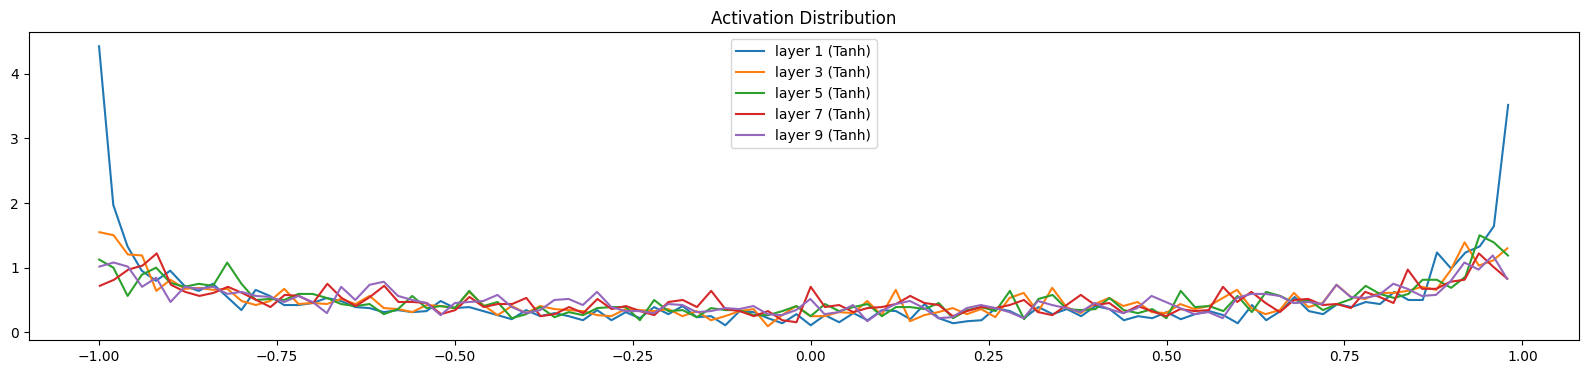

In [81]:
# visualise histograms

plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100)) 
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

# saturation indicates share of values in extreme ranges (> abs 0.97)

# if we did not use the 5/3 gain we would get 0% saturation
# K: the gain is necessary to balance the squashing tendency of the tanh layers
#    empirically this works, but not clear where the 5/3 figure comes from

layer 1 (      Tanh): mean +0.00001, std 0.00042, saturated: 0.00%
layer 3 (      Tanh): mean -0.00001, std 0.00039, saturated: 0.00%
layer 5 (      Tanh): mean +0.00002, std 0.00037, saturated: 0.00%
layer 7 (      Tanh): mean +0.00000, std 0.00033, saturated: 0.00%
layer 9 (      Tanh): mean -0.00000, std 0.00030, saturated: 0.00%


Text(0.5, 1.0, 'Gradient Distribution')

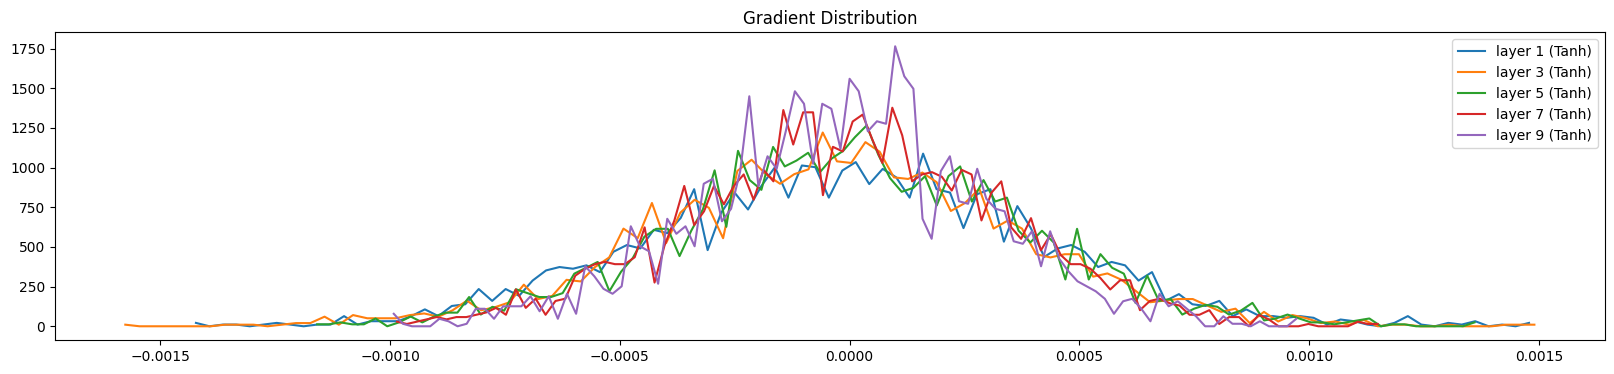

In [83]:
# do exact same thing as above, but with grads

plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.5f, std %.5f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100)) 
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

# K: setting gain too small expands gradients
#     I actually see larger stds with larger gain, and vice versa

# without tanh, the correct gain is exactly 1

In [85]:
# ----------------------
# WHY TANH??
# ----------------------

# given the above, why do we bother with tanh at all?
# K: If you have just a stack of linear layers, it collapses to a single linear layer
#    i.e. you end up with the same power as a single linear layer
#    (however, note that the optimisation would be different (between a single linear layer and multiple linear layers) )
#    essentially, the tanh layers allow us to turn the network into something that can approximate any arbitrary function

Weight:   (27, 10) 	Mean: -0.000080 	StD: 1.463118e-03 	Ratio, grad:data: 1.462061e-03
Weight:  (30, 100) 	Mean: -0.000005 	StD: 1.381055e-03 	Ratio, grad:data: 4.428400e-03
Weight: (100, 100) 	Mean: -0.000009 	StD: 1.174524e-03 	Ratio, grad:data: 7.070291e-03
Weight: (100, 100) 	Mean: +0.000001 	StD: 1.059326e-03 	Ratio, grad:data: 6.309856e-03
Weight: (100, 100) 	Mean: +0.000001 	StD: 9.542620e-04 	Ratio, grad:data: 5.707944e-03
Weight: (100, 100) 	Mean: +0.000012 	StD: 8.483325e-04 	Ratio, grad:data: 5.069414e-03
Weight:  (100, 27) 	Mean: +0.000000 	StD: 2.567337e-02 	Ratio, grad:data: 2.522635e+00


Text(0.5, 1.0, 'Weights Gradient Distribution')

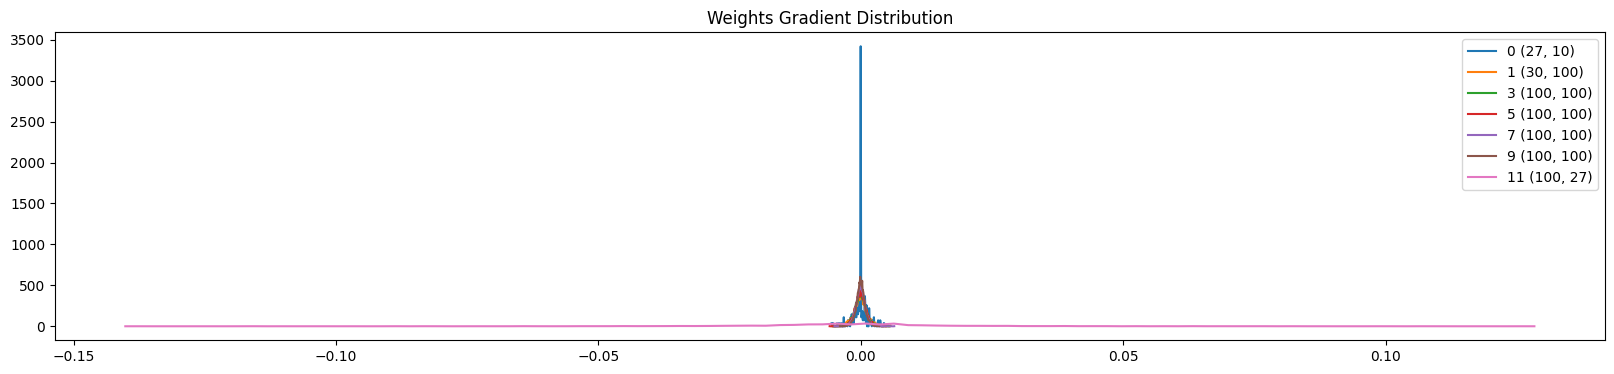

In [88]:
# plot gradient:data ratios

plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim ==2:        
        print(f'Weight: %10s \tMean: %+f \tStD: %e \tRatio, grad:data: %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient Distribution')

# K: gradient:data ratio is important because we are going later to take a step update
#    that uses the learning rate, gradient and data (I think)
#    and it's good that the gradients in all but the last layer are about 1,000 times smaller than the data
#    the discrepancy with the output layer will diminish after several iterations
#    (we are currently breaking after 1 iteration)

In [117]:
# track updates to data
ud = []

def train(train_runs, X_trn, Y_trn, batch_size, C, parameters, layers, step_i, loss_i, log_loss_i, ud):
    
    for _ in range (train_runs):
        ix = torch.randint(0, X_trn.shape[0], (batch_size,), generator = g)
        Xb, Yb = X_trn[ix], Y_trn[ix]
        
        # forward pass
        emb = C[Xb] # embed chars into vecs
        emb_concat = emb.view(emb.shape[0], -1) # concat vecs
        for layer in layers:
            emb_concat = layer(emb_concat)
        loss = F.cross_entropy(emb_concat, Yb) # loss function

        # backward pass
        for layer in layers:
            layer.out.retain_grad() # remove retain_grad after debugging
        for p in parameters:
            p.grad = None 
        loss.backward() 

        # update
        # l_rate = l_rate_init * (decay_factor ** _) # different from Karpathy's, below
        l_rate = 0.1 if _ < 100000 else 0.01 # K's
        for p in parameters:
            p.data += -l_rate * p.grad
            
        step_i.append(_)
        loss_i.append(loss) 
        log_loss_i.append(loss.log10().item()) 
        with torch.no_grad():
            ud.append([ ( l_rate * p.grad.std() / p.data.std() ).log10().item() for p in parameters ])

        if _ % 250 == 0:
            print(f'Iter: {_}\t'
                  f'L_rate: {round(l_rate, 5)}\t'
                  f'Loss: {round(loss.item(), 5)}\t'
                  f'Loss MA10: {round(np.mean([l.detach().numpy() for l in loss_i[-10:]]), 5)}')

In [102]:
train_runs = 10001

train(train_runs, X_trn, Y_trn, batch_size, C, parameters, layers, step_i, loss_i, log_loss_i)

Iter: 0	L_rate: 0.1	Loss: 2.28712	Loss MA10: 2.281169891357422
Iter: 250	L_rate: 0.1	Loss: 2.4295	Loss MA10: 2.349440097808838
Iter: 500	L_rate: 0.1	Loss: 2.06102	Loss MA10: 2.230299949645996
Iter: 750	L_rate: 0.1	Loss: 2.26881	Loss MA10: 2.3802199363708496
Iter: 1000	L_rate: 0.1	Loss: 2.31313	Loss MA10: 2.2924299240112305
Iter: 1250	L_rate: 0.1	Loss: 2.26458	Loss MA10: 2.1948299407958984
Iter: 1500	L_rate: 0.1	Loss: 2.46188	Loss MA10: 2.3012900352478027
Iter: 1750	L_rate: 0.1	Loss: 2.35759	Loss MA10: 2.286639928817749
Iter: 2000	L_rate: 0.1	Loss: 2.15125	Loss MA10: 2.249160051345825
Iter: 2250	L_rate: 0.1	Loss: 2.32228	Loss MA10: 2.343250036239624
Iter: 2500	L_rate: 0.1	Loss: 2.02787	Loss MA10: 2.286259889602661
Iter: 2750	L_rate: 0.1	Loss: 2.34357	Loss MA10: 2.2543699741363525
Iter: 3000	L_rate: 0.1	Loss: 2.54376	Loss MA10: 2.1902499198913574
Iter: 3250	L_rate: 0.1	Loss: 2.61755	Loss MA10: 2.3077099323272705
Iter: 3500	L_rate: 0.1	Loss: 1.91884	Loss MA10: 2.1661999225616455
Iter: 375

layer 1 (      Tanh): mean -0.06, std 0.79, saturated: 27.06%
layer 3 (      Tanh): mean +0.01, std 0.80, saturated: 26.97%
layer 5 (      Tanh): mean -0.03, std 0.82, saturated: 30.56%
layer 7 (      Tanh): mean -0.02, std 0.83, saturated: 31.19%
layer 9 (      Tanh): mean -0.01, std 0.76, saturated: 20.84%


Text(0.5, 1.0, 'Activation Distribution')

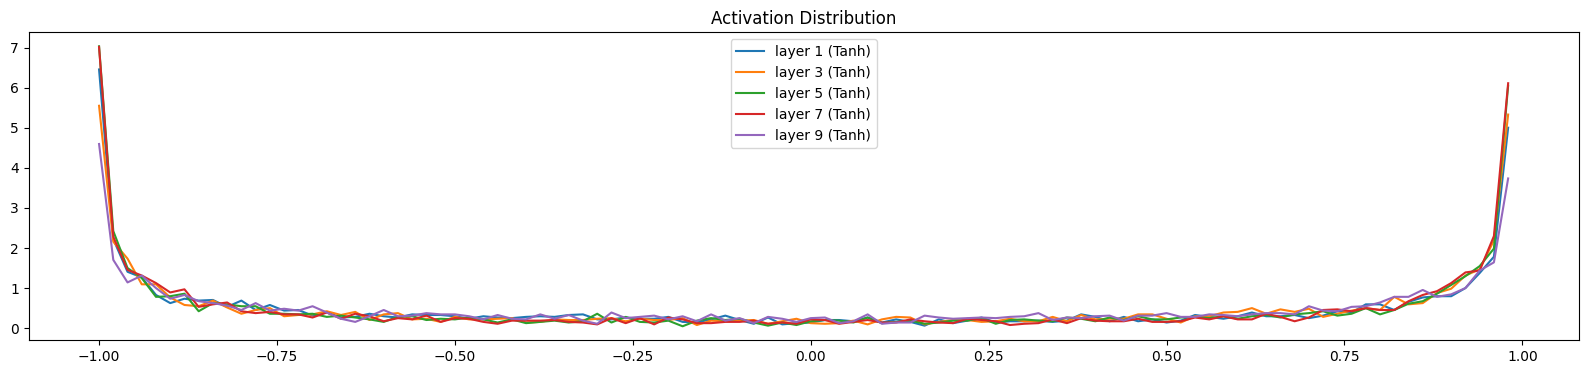

In [103]:
# plot same three plots as before

plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100)) 
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

layer 1 (      Tanh): mean +0.00006, std 0.00369, saturated: 0.00%
layer 3 (      Tanh): mean +0.00000, std 0.00312, saturated: 0.00%
layer 5 (      Tanh): mean +0.00004, std 0.00299, saturated: 0.00%
layer 7 (      Tanh): mean -0.00001, std 0.00333, saturated: 0.00%
layer 9 (      Tanh): mean +0.00005, std 0.00344, saturated: 0.00%


Text(0.5, 1.0, 'Gradient Distribution')

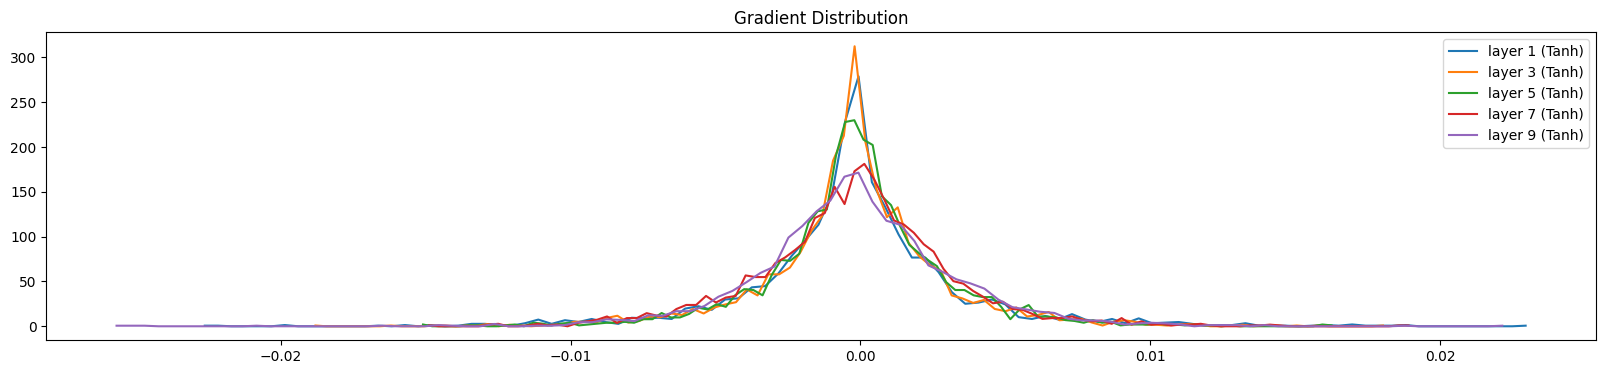

In [104]:
plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.5f, std %.5f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100)) 
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

Weight:   (27, 10) 	Mean: +0.002035 	StD: 1.446730e-02 	Ratio, grad:data: 1.387345e-02
Weight:  (30, 100) 	Mean: -0.000031 	StD: 9.939259e-03 	Ratio, grad:data: 2.929365e-02
Weight: (100, 100) 	Mean: +0.000183 	StD: 7.582407e-03 	Ratio, grad:data: 3.984124e-02
Weight: (100, 100) 	Mean: -0.000067 	StD: 6.583794e-03 	Ratio, grad:data: 3.486865e-02
Weight: (100, 100) 	Mean: +0.000092 	StD: 6.486036e-03 	Ratio, grad:data: 3.482002e-02
Weight: (100, 100) 	Mean: -0.000014 	StD: 6.871086e-03 	Ratio, grad:data: 3.867580e-02
Weight:  (100, 27) 	Mean: -0.000000 	StD: 2.067156e-02 	Ratio, grad:data: 1.701425e-01


Text(0.5, 1.0, 'Weights Gradient Distribution')

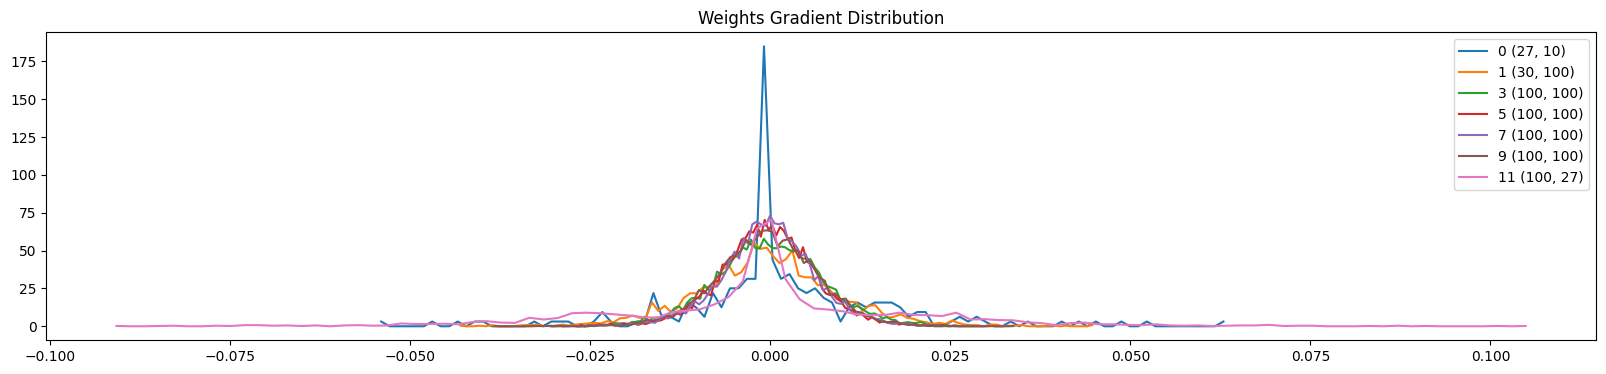

In [105]:
plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim ==2:        
        print(f'Weight: %10s \tMean: %+f \tStD: %e \tRatio, grad:data: %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient Distribution')

Text(0.5, 1.0, 'Update Ratios Over Time')

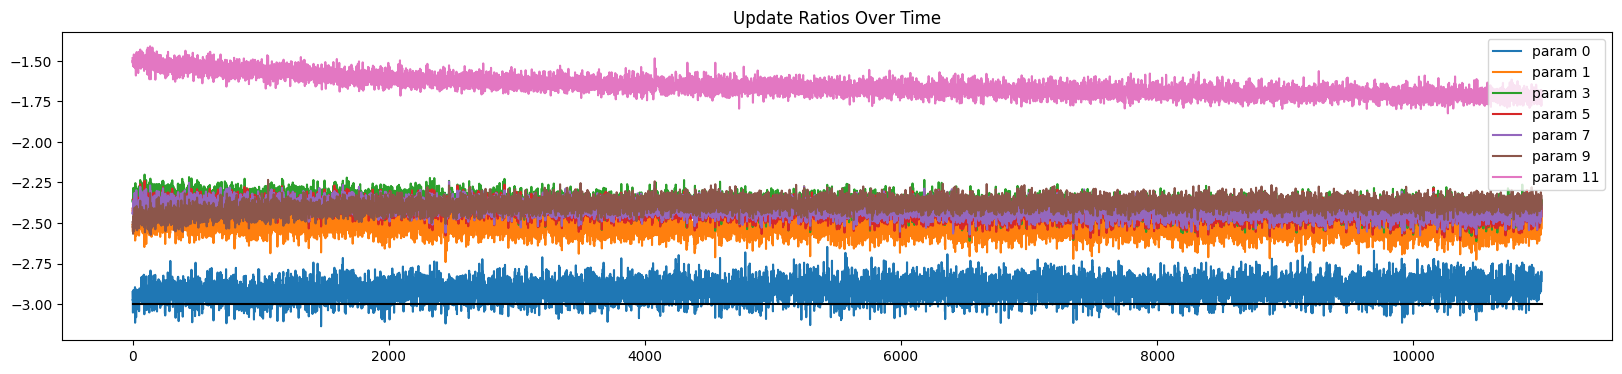

In [109]:
plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim ==2:        
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # plot 1e-3. ratios should be along this line
plt.legend(legends);
plt.title('Update Ratios Over Time')

# K: final layer will appear as an outlier as the final layer was shrunk earlier in order to reduce confidence at init
#    stablises over time
#    if learning rate is too low, updates will appear much smaller, e.g. 1e-6
#    1e-1 would indicate learning way too fast, 1e-6 too slow

In [110]:
# K: miscalibrations can still throw things out of whack
#    and we're still balancing a pencil of a finger
#    how can we make this easier?
#    batch norm layers

In [111]:
# add bn layers to the layer construction below

class Linear:
    # mirrors torch.nn.linear (without 'device' and 'dtype' args)
    
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5 # kaiming init, also used by torch
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    # mirrors torch.nn.BatchNorm1d 
    # (without 'affine', 'track_running_stats', device' and 'dtype' args, which here act as defaults)
    
    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # also exists in torch. set to False if testing rather than training
        
        # parameters - trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers - running measures updated according to momentum
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # forward pass
        if self.training:
            x_mean = x.mean(0, keepdim = True) # batch mean and variance
            x_var = x.var(0, keepdim = True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean) / (torch.sqrt(x_var + self.eps)) #  normalise to unit variance
        self.out = self.gamma * x_hat + self.beta
        
        #update buffers
        if self.training:
            with torch.no_grad(): # buffers don't require gradients, so inefficient to use grads on them
                self.running_mean = ( (1 - self.momentum) * self.running_mean ) + (self.momentum * x_mean)
                self.running_var = ( (1 - self.momentum) * self.running_var ) + (self.momentum * x_var)
        
        return self.out # NB - 'out' does not exist in torch. we're using them here to chart and evaluate later
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # n of char embedding Dims
n_hidden = 100 # n of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)









# --------------------------
# define shape of network
# add BN layers!!
# standard placement is between the linear and non-linear layers
# HOWEVER, you can also place it after the non-linear layers
# OR right at the end, after the output layer (with vocab_size rather than n_hidden neurons)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

# NOTE - because last layer is BN, we change gamma rather than weight
with torch.no_grad():
    # last layer - make less confident at init
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers - apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
# --------------------------            
            
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

47551

In [119]:
step_i, loss_i, log_loss_i, ud = [], [], [], []
train_runs = 10001

train(train_runs, X_trn, Y_trn, batch_size, C, parameters, layers, step_i, loss_i, log_loss_i, ud)

Iter: 0	L_rate: 0.1	Loss: 2.2113	Loss MA10: 2.2112998962402344
Iter: 250	L_rate: 0.1	Loss: 2.20905	Loss MA10: 2.1547598838806152
Iter: 500	L_rate: 0.1	Loss: 2.25381	Loss MA10: 2.272819995880127
Iter: 750	L_rate: 0.1	Loss: 2.67731	Loss MA10: 2.2807600498199463
Iter: 1000	L_rate: 0.1	Loss: 2.73655	Loss MA10: 2.3837599754333496
Iter: 1250	L_rate: 0.1	Loss: 2.13532	Loss MA10: 2.1362600326538086
Iter: 1500	L_rate: 0.1	Loss: 1.87641	Loss MA10: 2.1999599933624268
Iter: 1750	L_rate: 0.1	Loss: 2.30103	Loss MA10: 2.292680025100708
Iter: 2000	L_rate: 0.1	Loss: 2.19734	Loss MA10: 2.136539936065674
Iter: 2250	L_rate: 0.1	Loss: 2.12482	Loss MA10: 2.1565399169921875
Iter: 2500	L_rate: 0.1	Loss: 2.17496	Loss MA10: 2.3120501041412354
Iter: 2750	L_rate: 0.1	Loss: 2.37309	Loss MA10: 2.2094199657440186
Iter: 3000	L_rate: 0.1	Loss: 2.10969	Loss MA10: 2.174329996109009
Iter: 3250	L_rate: 0.1	Loss: 2.54922	Loss MA10: 2.202080011367798
Iter: 3500	L_rate: 0.1	Loss: 2.3759	Loss MA10: 2.237689971923828
Iter: 375

layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 5.94%
layer 5 (      Tanh): mean -0.01, std 0.67, saturated: 6.38%
layer 8 (      Tanh): mean -0.01, std 0.68, saturated: 6.12%
layer 11 (      Tanh): mean -0.00, std 0.69, saturated: 5.38%
layer 14 (      Tanh): mean -0.01, std 0.70, saturated: 3.97%


Text(0.5, 1.0, 'Activation Distribution')

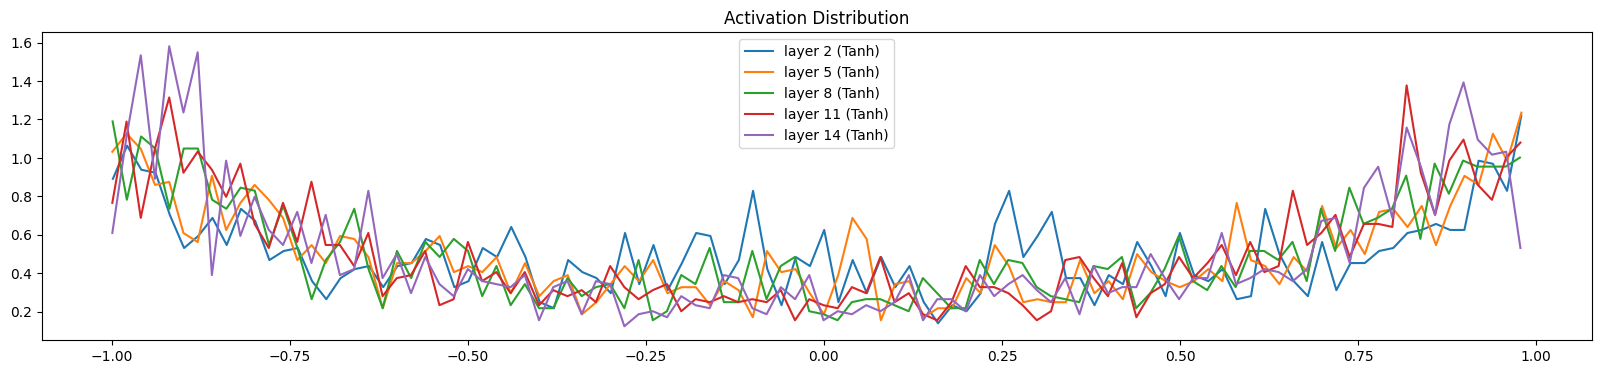

In [126]:
# plot visualisations

# NB because of batch norming, we can change e.g. kaiming init, fan-in norm, and get good charts
# EXCEPT for the learning rate chart, which will be affected and may need to be tuned to adjust
# (this is not done here, but is demoed in the video)

plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100)) 
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

layer 2 (      Tanh): mean -0.00000, std 0.00316, saturated: 0.00%
layer 5 (      Tanh): mean -0.00000, std 0.00286, saturated: 0.00%
layer 8 (      Tanh): mean -0.00000, std 0.00296, saturated: 0.00%
layer 11 (      Tanh): mean +0.00000, std 0.00291, saturated: 0.00%
layer 14 (      Tanh): mean +0.00000, std 0.00301, saturated: 0.00%


Text(0.5, 1.0, 'Gradient Distribution')

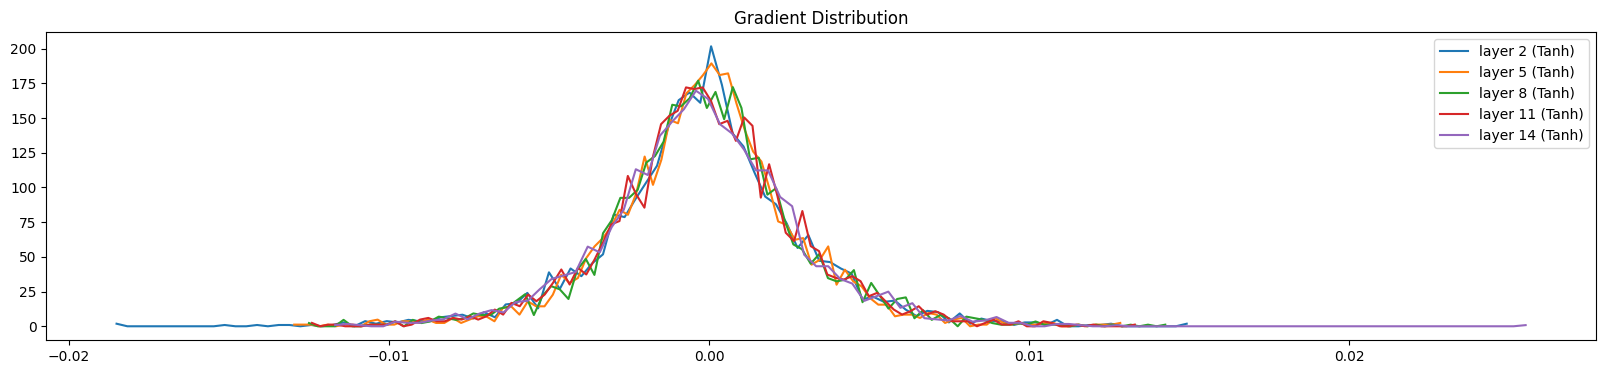

In [121]:
plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.5f, std %.5f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100)) 
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')

Weight:   (27, 10) 	Mean: +0.000000 	StD: 1.231247e-02 	Ratio, grad:data: 1.215498e-02
Weight:  (30, 100) 	Mean: +0.000088 	StD: 8.333935e-03 	Ratio, grad:data: 2.503886e-02
Weight: (100, 100) 	Mean: -0.000051 	StD: 5.328267e-03 	Ratio, grad:data: 2.837576e-02
Weight: (100, 100) 	Mean: -0.000032 	StD: 4.845661e-03 	Ratio, grad:data: 2.602278e-02
Weight: (100, 100) 	Mean: -0.000102 	StD: 4.915608e-03 	Ratio, grad:data: 2.671489e-02
Weight: (100, 100) 	Mean: -0.000109 	StD: 4.728514e-03 	Ratio, grad:data: 2.597312e-02
Weight:  (100, 27) 	Mean: +0.000045 	StD: 8.839942e-03 	Ratio, grad:data: 4.079038e-02


Text(0.5, 1.0, 'Weights Gradient Distribution')

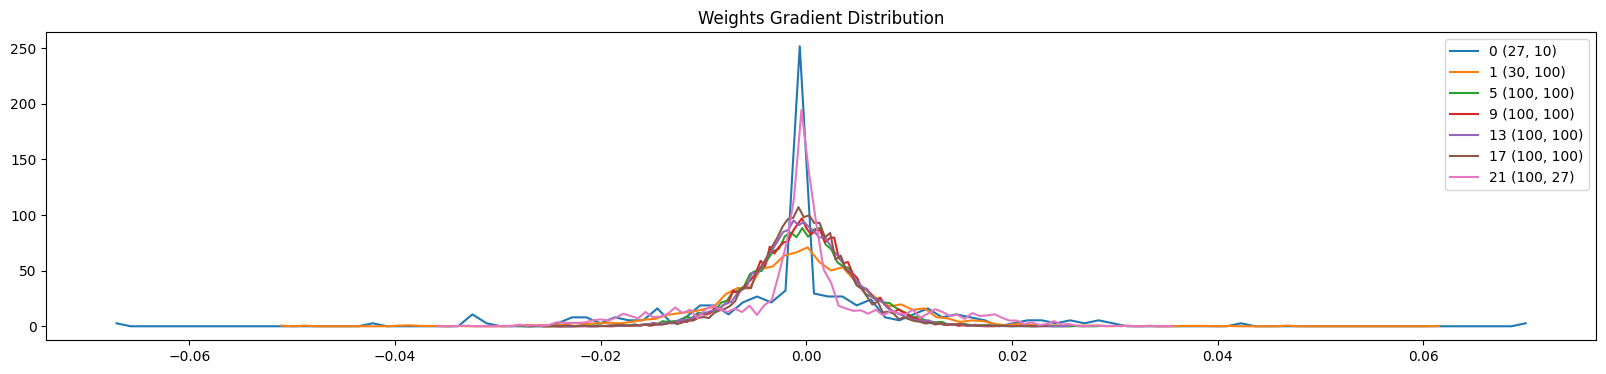

In [122]:
plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim ==2:        
        print(f'Weight: %10s \tMean: %+f \tStD: %e \tRatio, grad:data: %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient Distribution')

Text(0.5, 1.0, 'Update Ratios Over Time')

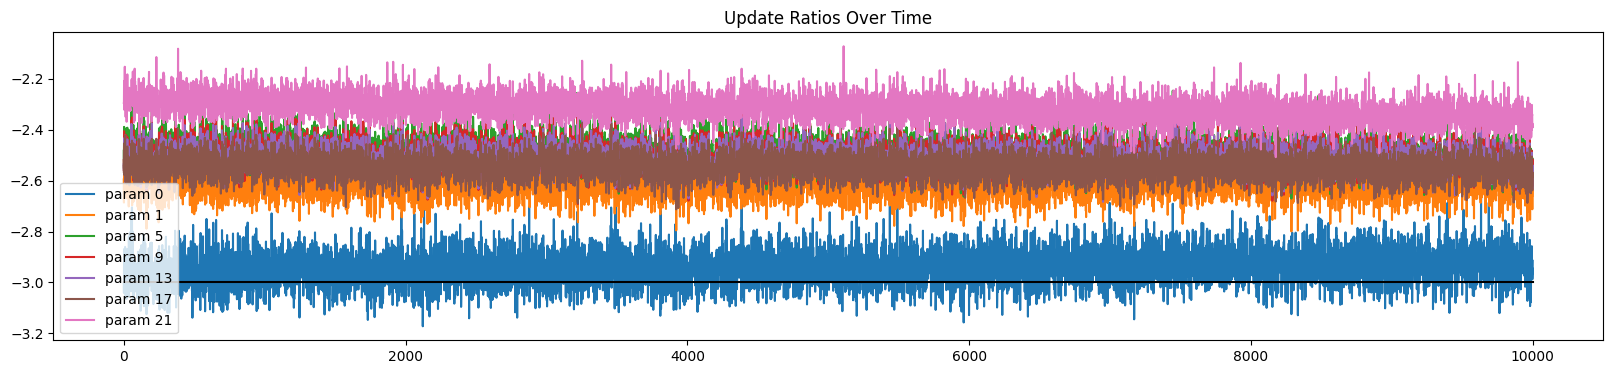

In [123]:
plt.figure(figsize = (20, 4))
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim ==2:        
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # plot 1e-3. ratios should be along this line
plt.legend(legends);
plt.title('Update Ratios Over Time')

In [127]:
# SUMMARY

# key points

# we reviewed batch normalisation helped to stabilise very deep neural networks
# we pytorch-ified our code and demonstrated how this code can be used to build NNs quickly
#     our build is so close to torch that we can simply import torch and prepend e.g. Linear, BatchNorm1d, Tanh
#     with nn. , and it will run the same
# we reviewed the tools that one would use to diagnose the health of a neural network

# what we DIDN'T do

# did not try to outperform previous performance
#     our performance at this stage is bottlenecked by context length 
#     and requires more powerful architectures, eg RNN/transformer
# did not try to fully explain the statistics behind the visualisations 
#     and why the results we take to be good, are good

# all the same, despite any 'shortcomings', we are now touching the boundaries of understanding in the field late 2022/early 23